# データセットの作成

ファインチューニング用のデータセットをOpenAIのGPT APIを使って作成します。

In [1]:
import os
import re
import time
import json

import pandas as pd
import numpy as np
from rich import print
from tqdm import tqdm
import japanize_matplotlib

from dotenv import load_dotenv

load_dotenv() 

import openai
openai.api_type = "azure"
openai.api_base = "https://gpt-l4-exp-oepnai-exp.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
openai.api_key = os.getenv("OPENAI_API_KEY")

CHAT_MODEL_DEPLOYMENT_NAME = os.environ.get('CHAT_MODEL_DEPLOYMENT_NAME')
EMBE_MODEL_DEPLOYMENT_NAME = os.environ.get('EMBE_MODEL_DEPLOYMENT_NAME')
# CHAT_MODEL_DEPLOYMENT_NAME, EMBE_MODEL_DEPLOYMENT_NAME

import litellm

litellm.api_type = "azure"
litellm.api_base = "https://gpt-l4-exp-oepnai-exp.openai.azure.com/"
litellm.api_version = "2023-07-01-preview"
litellm.api_key = os.getenv("OPENAI_API_KEY")
temperature = 0

('chatgpt-35', 'tea2')

Function Callingで学習用データを作成する

タグの定義

In [4]:
gp_list_df = pd.read_csv("data/gplist.csv")
product_tags_list = (gp_list_df['日本語'] + '(' + gp_list_df['説明'] + ')').to_list()

In [5]:
sub_category_csv = """
観点
商品知識
接客態度
レジ処理の速度
店内の清潔度
店内レイアウト
商品陳列
商品在庫
欠品
照明設備
音響設備
駐車場
空調
安全対策
トイレ設備
ハンディキャップ対応
"""
from io import StringIO
sub_category_df = pd.read_csv(StringIO(sub_category_csv))
service_store_tags_list = sub_category_df['観点'].to_list()

In [6]:
tags_list = []
tags_list += product_tags_list
tags_list += service_store_tags_list
# tags_list

関数の定義

In [49]:
function_schema = [  
    {
        "name": "classify_comment",
        "description": "Select 'categories' and 'tags' based on the content of the comment body. Also, excerpt important topic keywords and include them in 'keywords'.",
        "parameters": {
            "type": "object",
            "properties": {
                "categories": {
                    "type": "string",
                    "enum": ["商品", "サービス・設備"],
                    "description": "The category of the comment"
                },
                "tags": {
                    "type": "array",
                    "items": {
                        "type": "string",
                        "enum": tags_list
                    },
                    "description": "Tags related to the comment. **A description is written in brackets behind the tag. No parentheses are required after the parentheses when tagging.**"
                },
                "keywords": {
                    "type": "array",
                    "items": {
                        "type": "string"
                    },
                    "description": "Important topic keywords extracted from the comment"
                }
            },
            "required": ["categories", "tags", "keywords"]
        }
    }
]  

In [50]:
with open('./data/comments.txt', encoding='utf-8') as f:
    voc_comments = f.readlines()
voc_comments = [comment.replace("\n", "") for comment in voc_comments]
voc_comments[:5]

['オートチャージで丁寧に教えてくれた。感謝。',
 'スプレッドで、明治スプレッタブルという商品を置いてほしい。しょうゆとマヨネーズは安めにしてほしい。お菓子はスーパーと値段がほぼ変わらないので季節ものの商品は安めに置いて頂くとかしたらわざわざ買いに行く価値があるかと思います。',
 'シャンプーのジュレームを安くしてほしい',
 'いつも、Aさんの対応が素晴らしい。これからも頑張ってください。',
 '頻繁に売り場が、急に変わるのが困ります。']

In [52]:
results = []

タグ付けの実行

1299件で1時間6分 = 1件19秒

In [53]:
for i in tqdm(range(0, len(voc_comments))):
    messages = [
        {"role": "system", "content": "You receive comments from customers. For each comment, you select arguments for function input to perform the appropriate processing. Input from user is a comment from a customer."},
        {"role": "user", "content": voc_comments[i]}]

    response = litellm.completion(
        f"azure/{CHAT_MODEL_DEPLOYMENT_NAME}",
        messages=messages,
        functions=function_schema,
        temperature=temperature,
        stream=False,
        )
    results.append({
        'input': voc_comments[i],
        'output': response
    })
    time.sleep(1)
    

100%|██████████| 1299/1299 [1:11:37<00:00,  3.31s/it]


In [63]:
print(voc_comments[-1],response.choices[0].message.function_call.arguments)

なし。 {
  "categories": "",
  "tags": "",
  "keywords": []
}

In [136]:
def result_handler(result):
    output = result['output']
    try:
        if 'function_call' in output['choices'][0]['message']:
            return {
                'valid_format': True,
                'input': result['input'],
                'output': arguments_handler(json.loads(output['choices'][0]['message']['function_call']['arguments']))
            }
    except:
        print(output['choices'][0]['message']['function_call']['arguments'])
    return {
        'valid_format': False,
        'input': result['input'],
        # 'output': output
    }


results_json = list(map(result_handler, results))

{
  "categories": "サービス・設備",
  "tags": "接客態度(レジの担当の方が丁寧)", "店内の清潔度(トイレが綺麗)",
  "keywords": ["レジ", "担当", "丁寧", "嬉しい", "トイレ", "綺麗"]
}

In [101]:
with open('./data/09251400.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(results_json, ensure_ascii=False, indent=4))

保存

In [185]:

def arguments_handler(arguments):
    def string_handler(arg):
        """文字列型であれば文字列、そうでないならばリスト型"""
        if type(arg) == type(str()):
            return arg
        return [arg]

    def list_handler(arg):
        """リスト型に変換する"""
        if type(arg) == type(list()):
            return arg
        return [arg]

    def tag_handler(text):
        """`リカー＆ワイン( アルコール飲料とワイン)`から(*)の部分を削除する"""
        return re.sub(r'\([^)]*\)', '', text)
        
    def category_handler(text):
        """`商品`、`サービス・設備`、``のみを抽出する"""
        if text in ['商品', 'サービス・設備', '']:
            return text
        return None
        
    return {
        'categories': category_handler(string_handler(arguments['categories'])),
        'tags': list(map(tag_handler, list_handler(arguments['tags']))),
        'keywords': list_handler(arguments['keywords'])
    }

def result_handler(result):
    output = result['output']
    try:
        if 'function_call' in output['choices'][0]['message']:
            return {
                'valid_format': True,
                'input': result['input'],
                # 'output': arguments_handler(json.loads(output['choices'][0]['message']['function_call']['arguments']))
            } | arguments_handler(json.loads(output['choices'][0]['message']['function_call']['arguments']))
    except:
        print(output['choices'][0]['message']['function_call']['arguments'])
    return {
        'valid_format': False,
        'input': result['input'],
        # 'output': output
    }


results_json = list(map(result_handler, results))
# print(results_json)

{
  "categories": "サービス・設備",
  "tags": "接客態度(レジの担当の方が丁寧)", "店内の清潔度(トイレが綺麗)",
  "keywords": ["レジ", "担当", "丁寧", "嬉しい", "トイレ", "綺麗"]
}

In [137]:
with open('./data/09251400_fd.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(results_json, ensure_ascii=False, indent=4))

In [253]:
results_df = pd.DataFrame(results_json)
print(results_df.valid_format.sum() / (len(results_df) + 1))

results_df = results_df.query('valid_format == True')[['input', 'categories', 'tags', 'keywords']]
results_df.rename({'input': 'comment', 'categories':'category', 'tags':'tag'}, axis='columns', inplace=True)

results_df['tag'] = results_df['tag'].apply(lambda x: None if len(x) == 0 else x[0])
results_df.dropna(subset=['category'], inplace=True)

tags_list = list(pd.read_csv('data/カテゴリー・タグ定義.csv', encoding='cp932')['タグ'])
results_df = results_df.query('tag in @tags_list')

print(f'{len(results_df) / len(voc_comments):.4f}')

0.9892307692307692

0.8306

In [235]:
# results_df.query('category == "ペット＆ガーデン"')

<Axes: ylabel='tag'>

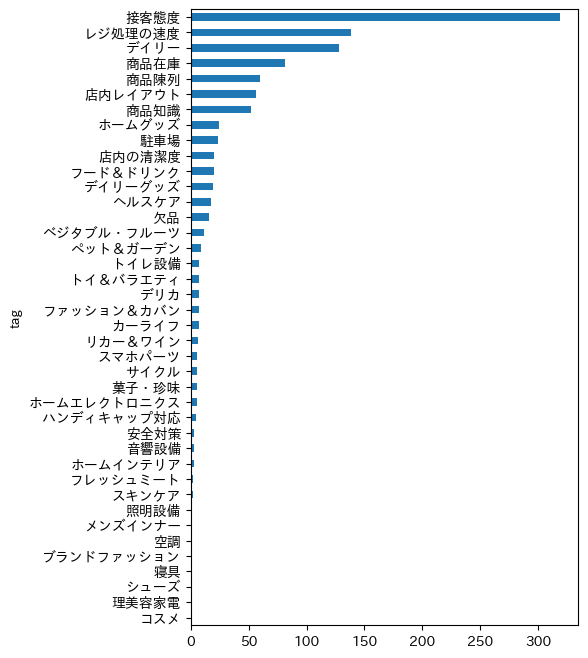

In [265]:
results_df['tag'].value_counts().sort_values(ascending=True).plot.barh(figsize=(5, 8))

In [270]:
results_df.to_csv('data/09281400.csv', index=False, encoding='utf-8')